In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

In [60]:
params_old_freon = {
    703394: {
        'params_low': [178.93452,  -0.070635304,  0.00000489,  0,  0],
        'params_high': [185.59784,  -0.07882956,  0.00000817,  0.0,  0.0],
        'slope_low_flow_min': 4298,
        'slope_low_flow_max': 2770,
        'slope_high_flow_max': 2013
    },
    703419: {
        'params_low': [238.224,  -0.16672891,  0.00005483,  -0.00000001, 0],
        'params_high': [200.08978,  -0.097593874,  0.00001254,  0.0,  0.0],
        'slope_low_flow_min': 4190,
        'slope_low_flow_max': 2640,
        'slope_high_flow_max': 1897
    },
}


    # 703423: {
    #     'params_low': [412.58548,  -0.3601924,  0.00013578,  -0.00000003,  0],
    #     'params_high': [185.3088,  -0.07946753,  0.00000807,  0.0,  0.0],
    #     'slope_low_flow_min': 4217,
    #     'slope_low_flow_max': 2690,
    #     'slope_high_flow_max': 1971
    # }

In [61]:
file_mix = 'calibration_2024-11-27_11-31-56.csv'
file_freon = 'calibration_2024-11-27_13-49-16.csv'

df_mix = pd.read_csv(file_mix)
df_freon = pd.read_csv(file_freon)

barcodes = list(params_old_freon.keys())
# barcodes = sorted(list(set(list(df_freon['barcode1']) + list(df_freon['barcode2']))))

In [62]:
def process_data(df, is_dual_curve):
    degree_polynomial_low_flows = 3
    degree_polynomial_high_flows = 3
    flow_lists_low = dict()
    slope_lists_low = dict()
    calib_params_low = dict()
    flow_lists_high = dict()
    slope_lists_high = dict()
    calib_params_high = dict()
    # Initialize dictionaries
    for barcode in barcodes:
        for d in [flow_lists_low, slope_lists_low, calib_params_low, flow_lists_high, slope_lists_high, calib_params_high]:
            d[barcode] = []
    flow_limits = [-1, -1, -1] # [low_flow_min, low_flow_max, high_flow_max]
    slope_limits = dict() # For every barcode: [slope_low_flow_min, slope_low_flow_max, slope_high_flow_max]
    
    # Read flow and slope values
    for _, row in df.iterrows():
        if row['barcode1'] not in barcodes:
            continue
        if row['curve'] == 'low':
            flow_lists_low[row['barcode1']].append(row['flow'])
            flow_lists_low[row['barcode2']].append(row['flow'])
            slope_lists_low[row['barcode1']].append(row['slope1'])
            slope_lists_low[row['barcode2']].append(row['slope2'])
        else:
            flow_lists_high[row['barcode1']].append(row['flow'])
            flow_lists_high[row['barcode2']].append(row['flow'])
            slope_lists_high[row['barcode1']].append(row['slope1'])
            slope_lists_high[row['barcode2']].append(row['slope2'])
    
    # Determine flow limits for curves (same for all flowcells)
    flow_limits[0] = min(flow_lists_low[barcodes[0]])
    flow_limits[1] = max(flow_lists_low[barcodes[0]])
    if is_dual_curve:
        flow_limits[2] = max(flow_lists_high[barcodes[0]])
    low_flow_min, low_flow_max, high_flow_max = flow_limits
    
    for barcode in barcodes:
        # Calculate calibration parameters
        params_low = np.polynomial.polynomial.polyfit(
            x = slope_lists_low[barcode],
            y = flow_lists_low[barcode],
            deg = degree_polynomial_low_flows
        )
        calib_params_low[barcode] = np.pad(params_low, [0, 4-degree_polynomial_low_flows], mode='constant', constant_values=0.0)
        if is_dual_curve:
            params_high = np.polynomial.polynomial.polyfit(
                x = slope_lists_high[barcode],
                y = flow_lists_high[barcode],
                deg = degree_polynomial_high_flows
            )
            calib_params_high[barcode] = np.pad(params_high, [0, 4-degree_polynomial_high_flows], mode='constant', constant_values=0.0)
        # Determine slope limits by mapping flow limits onto slopes (with inverse polynomial fit)
        params_inverse_low = np.polynomial.polynomial.polyfit(flow_lists_low[barcode], slope_lists_low[barcode], degree_polynomial_low_flows)
        slope_low_flow_min = np.polynomial.polynomial.polyval(low_flow_min, params_inverse_low)
        slope_low_flow_max = np.polynomial.polynomial.polyval(low_flow_max, params_inverse_low)
        slope_limits[barcode] = [slope_low_flow_min, slope_low_flow_max, -1]
        if is_dual_curve:
            params_inverse_high = np.polynomial.polynomial.polyfit(flow_lists_high[barcode], slope_lists_high[barcode], degree_polynomial_high_flows)
            slope_high_flow_max = np.polynomial.polynomial.polyval(high_flow_max, params_inverse_high)
            slope_limits[barcode][2] = slope_high_flow_max
    return flow_lists_low, slope_lists_low, calib_params_low, flow_lists_high, slope_lists_high, calib_params_high, flow_limits, slope_limits


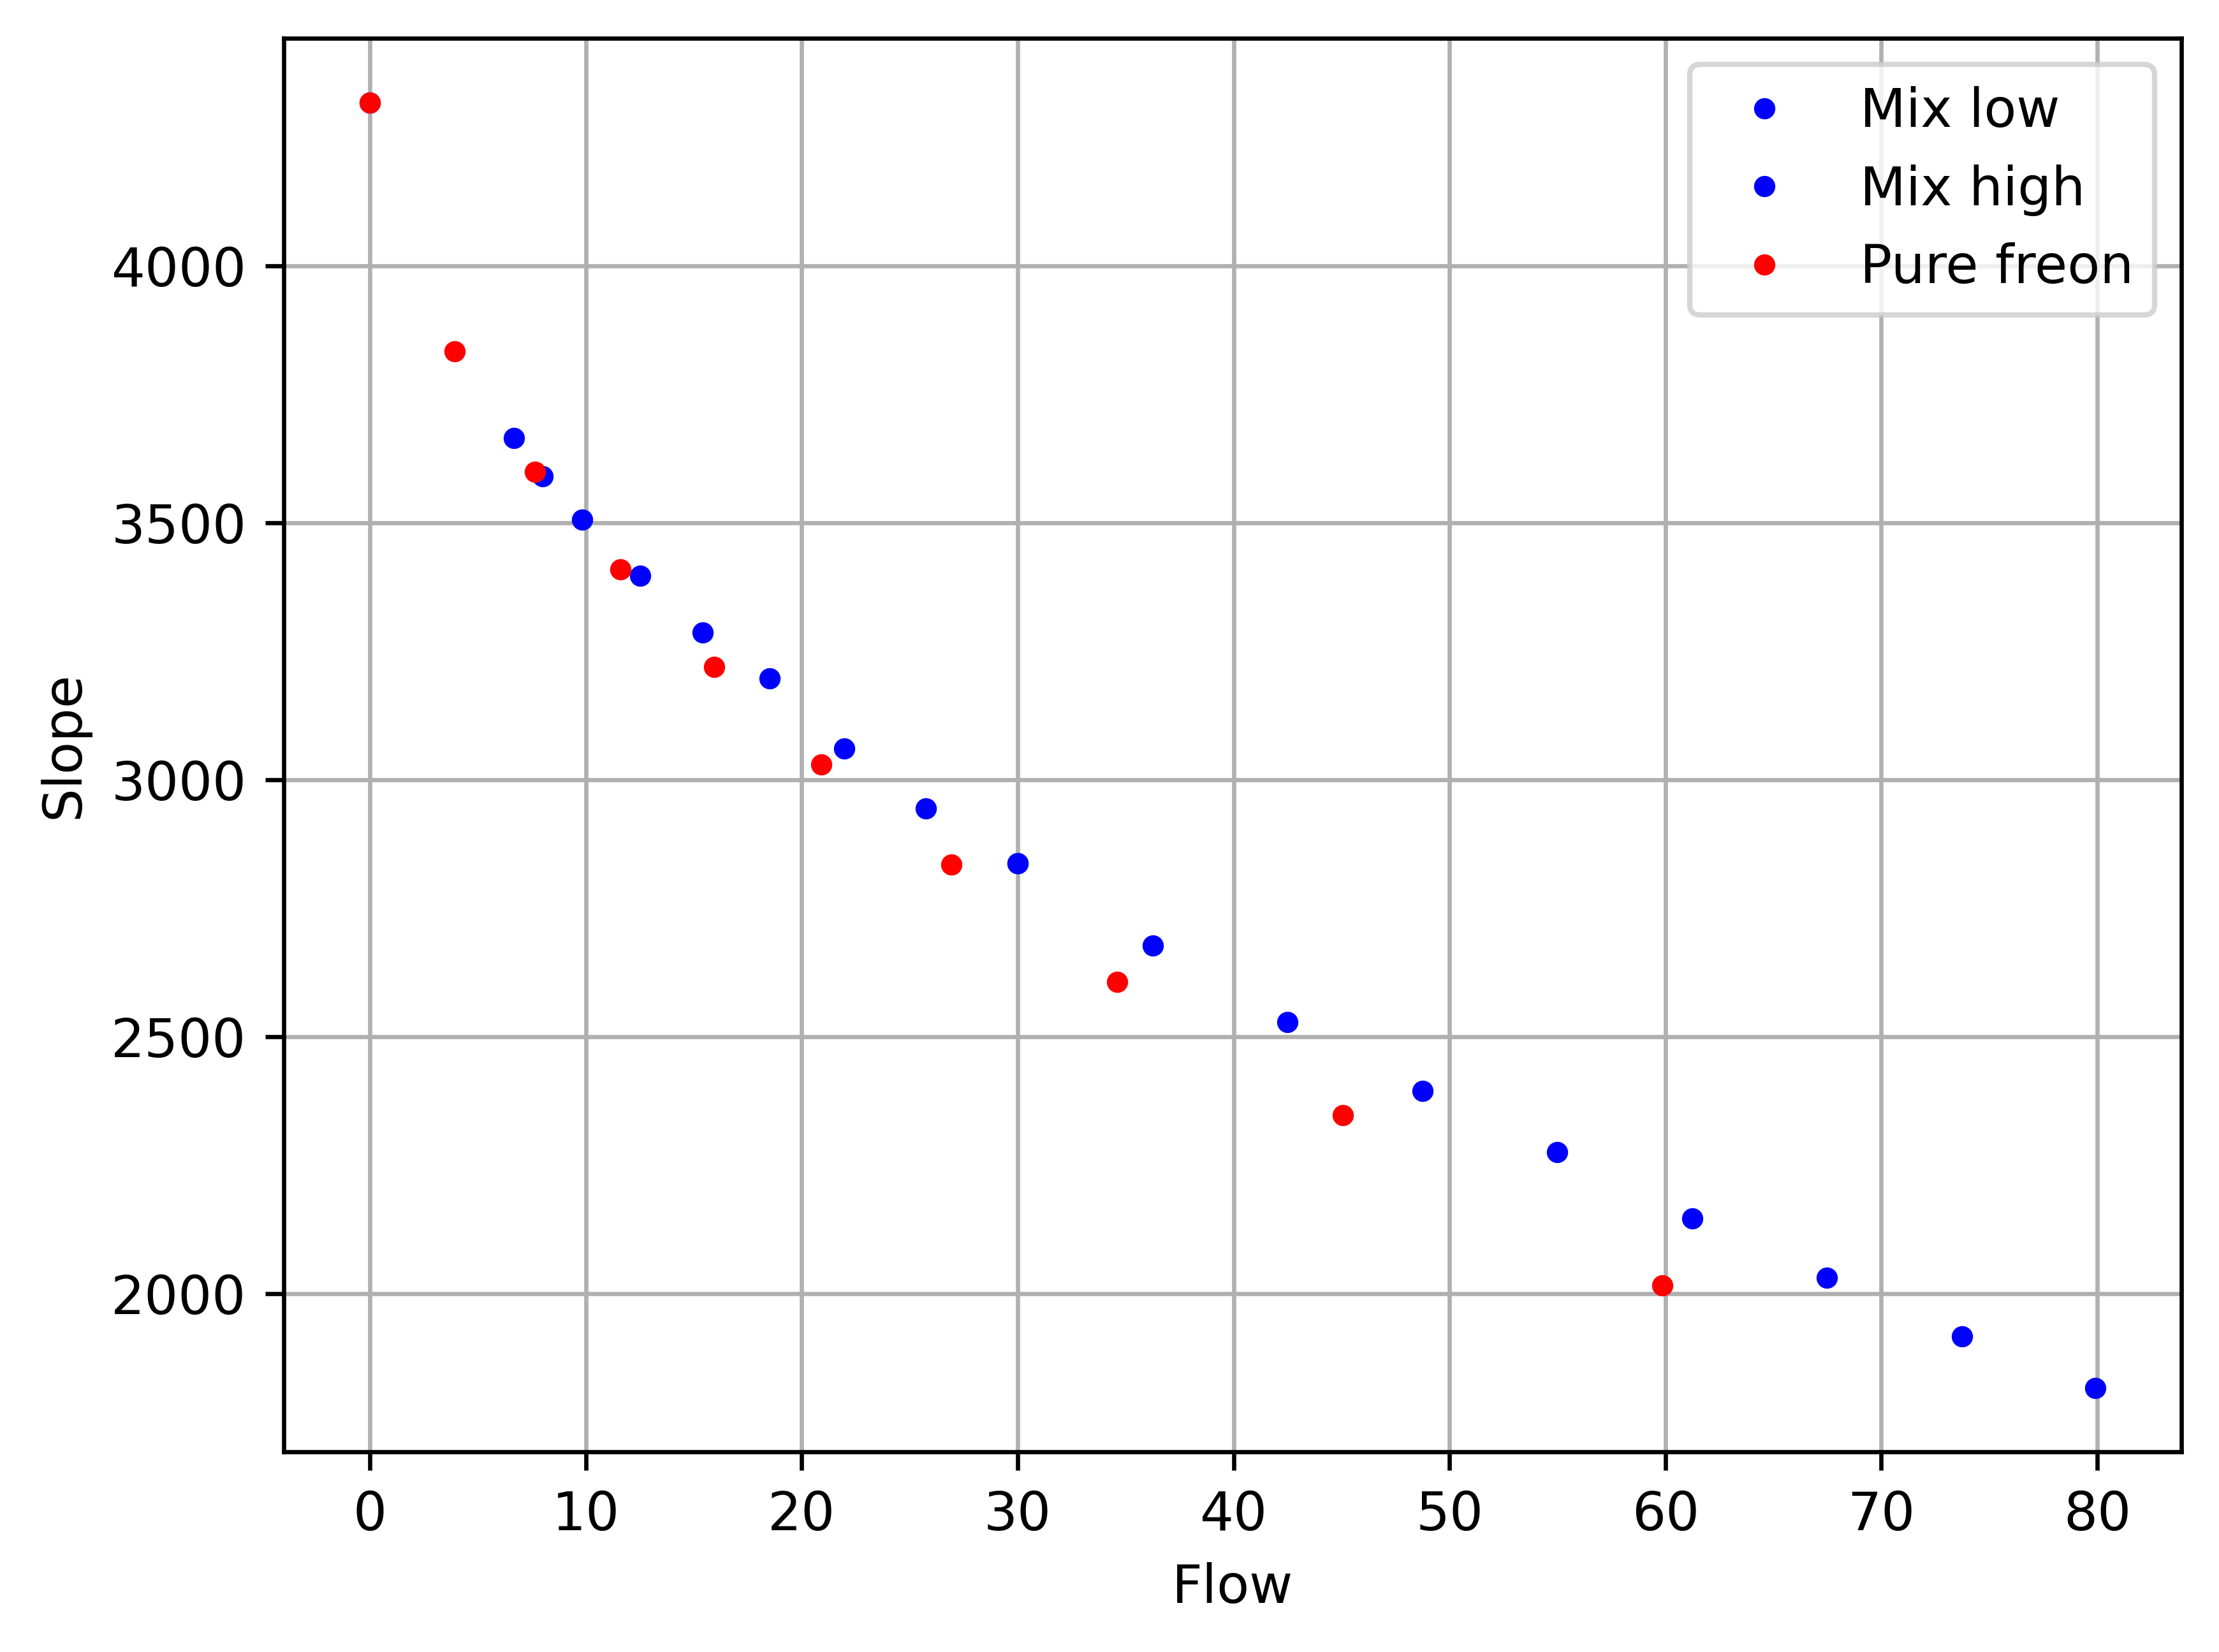

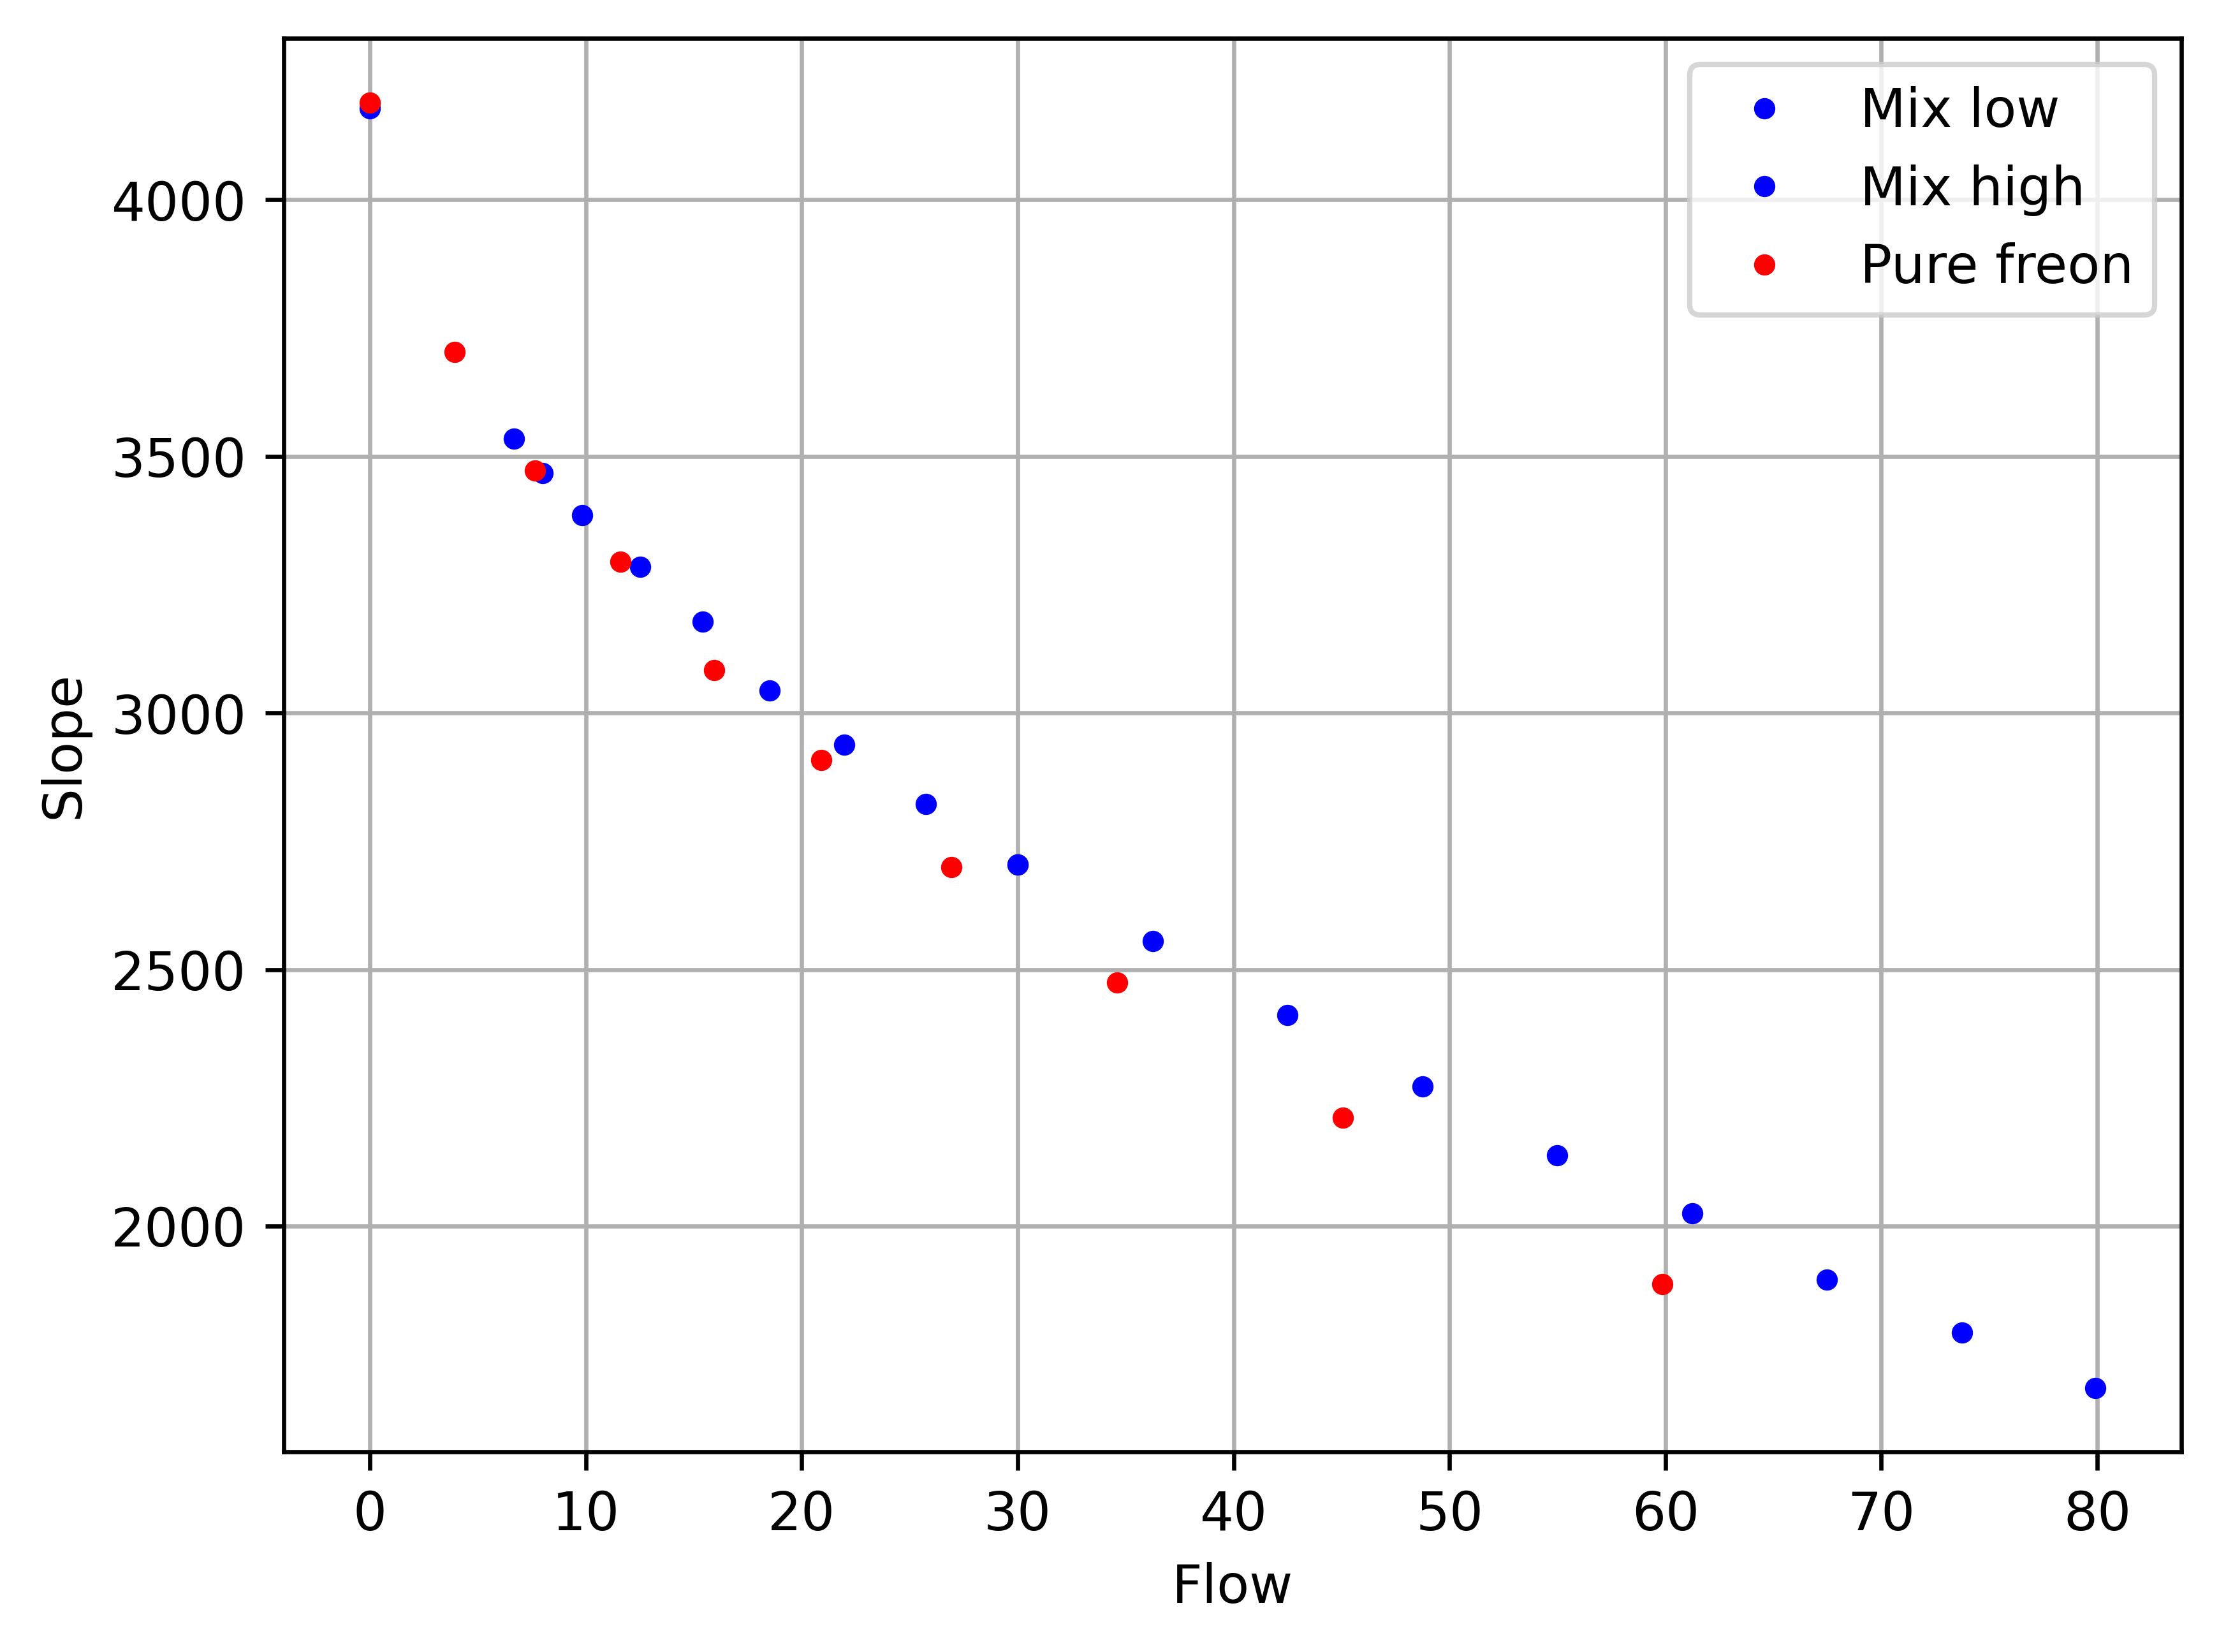

In [65]:
flow_lists_low_mix, slope_lists_low_mix, _, flow_lists_high_mix, slope_lists_high_mix, _, _, _ = process_data(df_mix, True)
flow_lists_low_freon, slope_lists_low_freon, _, _, _, _, _, _ = process_data(df_freon, False)

for b in barcodes[:5]:
    
    data_old = params_old_freon[b]
    
    plt.figure()
    plt.plot(flow_lists_low_mix[b], slope_lists_low_mix[b], 'b.', label='Mix low')
    plt.plot(flow_lists_high_mix[b], slope_lists_high_mix[b], 'b.', label='Mix high')
    plt.plot(flow_lists_low_freon[b], slope_lists_low_freon[b], 'r.', label='Pure freon')
    ss_low = np.linspace(data_old['slope_low_flow_max'], data_old['slope_low_flow_min'], 30)
    ss_high = np.linspace(data_old['slope_high_flow_max'], data_old['slope_low_flow_max'], 30)
    ff_low = [np.dot(data_old['params_low'], [1, x, x**2, x**3, x**4]) for x in ss_low]
    ff_high = [np.dot(data_old['params_high'], [1, x, x**2, x**3, x**4]) for x in ss_high]
    
    plt.xlabel('Flow')
    plt.ylabel('Slope')
    # plt.plot(ff_low, ss_low, 'k--')
    # plt.plot(ff_high, ss_high, 'k--')
    plt.legend()
    plt.grid()
    plt.show()




